In [191]:
from mpl_toolkits import mplot3d
from scipy.interpolate import CubicSpline
import scipy.io as scio
import numpy as np 
import matplotlib.pyplot as plt
data = scio.loadmat('tissue3_1.mat')

In [193]:
# Look at imported data
for key, value in data.items():
    print(key)
    
t24 = np.flip(data['map_t3'],0)  # Spectra at each spatial location
IDX = np.flip(data['IDX'],0)      # Values range from 1 to 15

__header__
__version__
__globals__
x_c
IDX
spC
dermis
k
m
dye
infl
bcc
map_t3
map_t3_c
map_t3_svd
tissue_t3_1
ID


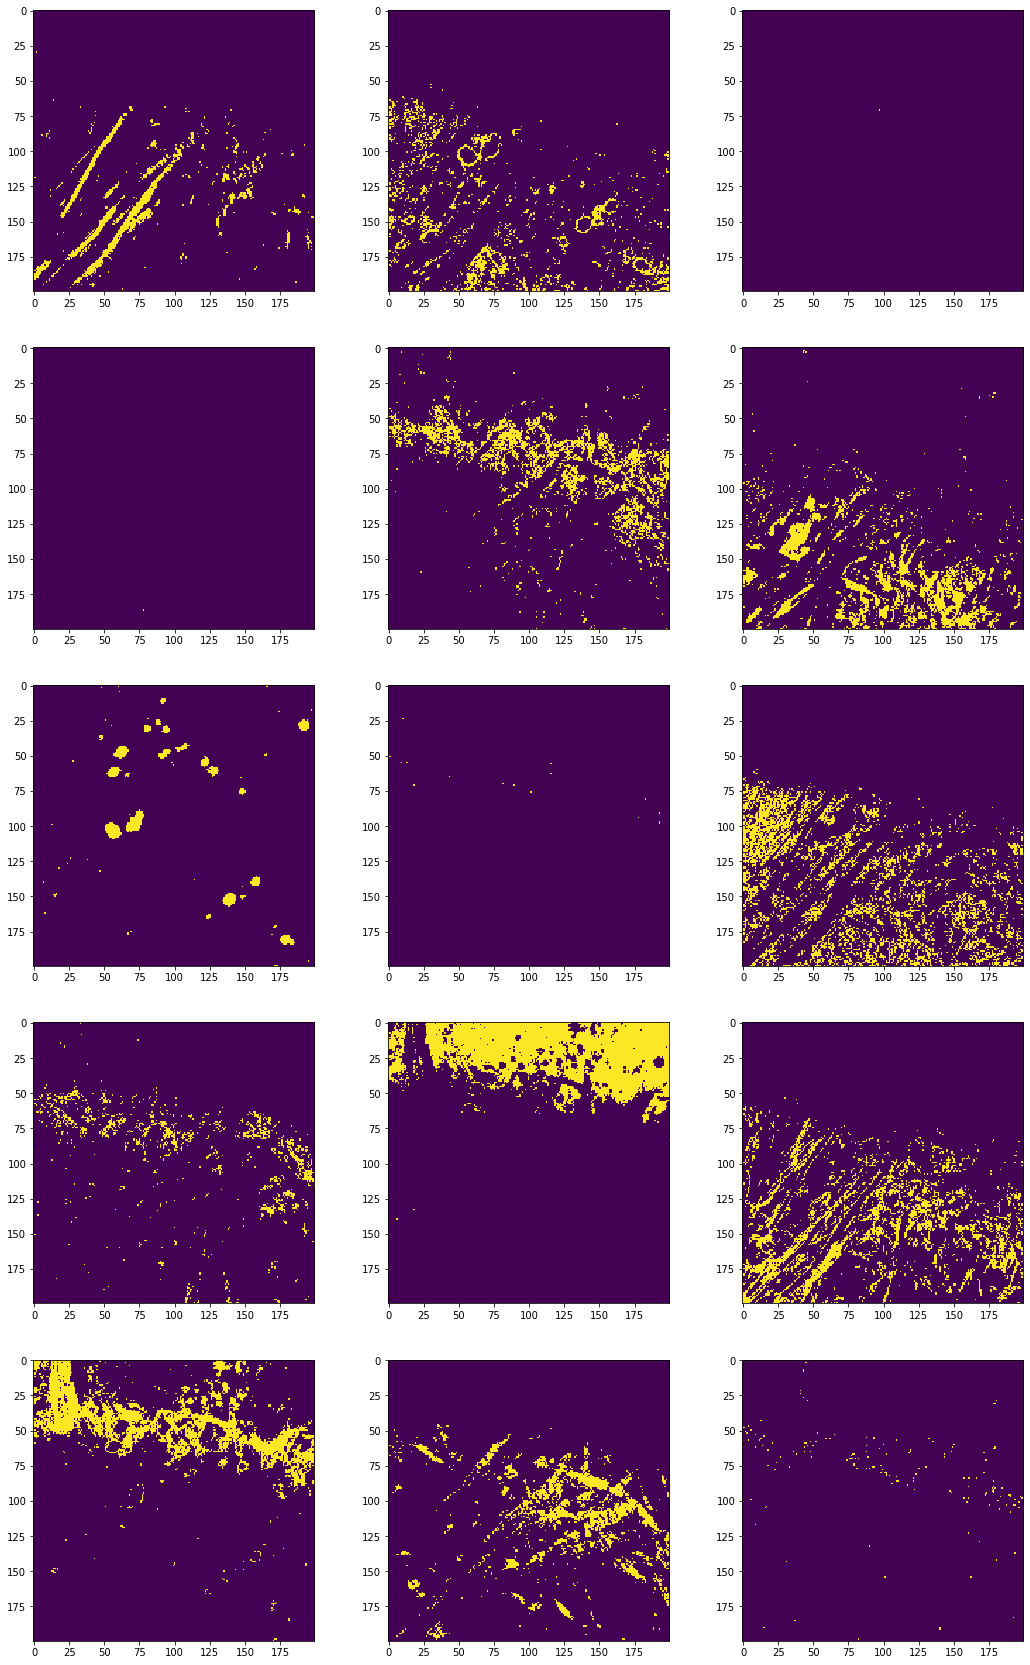

In [194]:
fig, ax = plt.subplots(5,3)
fig.set_size_inches(18, 30)

for i in range(5):
    for j in range(3):
        index = i*3 + j + 1 
        ax[i,j].imshow(IDX==index)

In [195]:
# Use rubber-band method to remove baseline
no_baseline = np.zeros((200,200,1024))
x = [i for i in range(1024)]
for m in range(200):
    for n in range(200):
        # Divide into sections and get min value
        intervals = int(1024/64)
        min_index = np.zeros(intervals)
        min_value = np.zeros(intervals)
        
        for i in range(intervals):
            min_index[i] = np.argmin(t24[m,n,64*i:64*i+63]) + 64*i
            min_value[i] = np.amin(t24[m,n,64*i:64*i+63])
            
        # Add more precise start/end
        s_index = np.argmin(t24[m,n,0:7])
        s_value = np.amin(t24[m,n,0:7])
        e_index = np.argmin(t24[m,n,1016:1023]) + 1016
        e_value = np.amin(t24[m,n,1016:1023])
        
        if s_index not in min_index:
            min_index = np.insert(min_index,0,s_index)
            min_value = np.insert(min_value,0,s_value)
        if e_index not in min_index:
            min_index = np.append(min_index,e_index)
            min_value = np.append(min_value,e_value)
        
        # Fit and remove spline
        cs = CubicSpline(min_index, min_value)
        no_baseline[m,n,:] = t24[m,n,:] - cs(x)

KeyboardInterrupt: 

In [196]:
# Create an average spectrum from each section identified in IDX
sections_data = {}
sections_data['avg_spectrum'] = np.zeros((15,1024))
sections_data['list_spectra'] = [[] for i in range(15)]
sections_data['numb_pts'] = np.zeros(15)

for section in range(15):
    sum_spectra = np.zeros(1024)
    count = 0
    
    for m in range(200):
        for n in range(200):
            if IDX[m,n] == section+1:
                sections_data['list_spectra'][section].append(t24[m,n,:])
                sum_spectra += t24[m,n,:]
                count += 1
                
    sections_data['avg_spectrum'][section,:] = sum_spectra/count
    sections_data['numb_pts'][section] = count  

In [204]:
for i in range(15):
    a = sections_data['numb_pts'][i]
    print(str(i) + '. ' + f'{a:.0f}')

0. 1827
1. 2573
2. 1
3. 1
4. 3744
5. 3793
6. 855
7. 16
8. 5368
9. 1509
10. 7210
11. 4886
12. 4835
13. 3214
14. 168


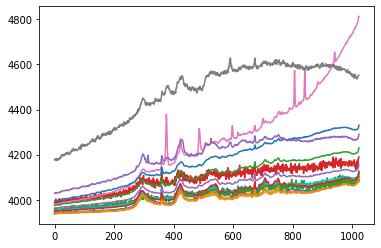

In [197]:
# Plot average spectra for each section
plt.figure()
for i in range(15):
    plt.plot(sections_data['avg_spectrum'][i,:])

In [205]:
# Get correlation of each spectra to each section
correlations = np.zeros((200,200,15))

for m in range(200):
    for n in range(200):
        for i in range(15):
            correlations[m,n,i] = np.corrcoef(t24[m,n,:],sections_data['avg_spectrum'][i,:])[0,1]

In [206]:
# See which section each point is most correlated to
# Check whether it coincides with the section it belongs to
correct = 0

for m in range(200):
    for n in range(200):
        max_index = np.argmax(correlations[m,n,:])
        
        if max_index == IDX[m,n]-1:
            correct += 1

print('Out of ' + str(200*200) + ' points, ' + str(correct) + ' are correctly grouped into their section.')
print('Percentage: ' + str(correct/(200*200)*100) + '%')

Out of 40000 points, 33285 are correctly grouped into their section.
Percentage: 83.2125%


In [207]:
# Update average removing outliers
def remove_outliers(data, threshold=0.95):
    new_data = {}
    new_data['avg_spectrum'] = np.zeros((15,1024))
    new_data['list_spectra'] = [[] for i in range(15)]
    new_data['numb_pts'] = np.zeros(15)

    for section in range(15):
        sum_spectra = np.zeros(1024)
        count = 0

        for spectra in data['list_spectra'][section]:
            correlation = np.corrcoef(spectra,data['avg_spectrum'][section,:])[0,1]
            if correlation > threshold: 
                new_data['list_spectra'][section].append(spectra)
                sum_spectra += spectra
                count += 1

        if count != 0:
            new_data['avg_spectrum'][section,:] = sum_spectra/count
            new_data['numb_pts'][section] = count  

    return new_data

In [208]:
for t in [0.9,0.905,0.91,0.915,0.92,0.925,0.93,0.935,0.94,0.945,0.95,0.955,0.96,0.965,0.97,0.975,0.98,0.985,0.99]:
    new_data = remove_outliers(sections_data, t)

    old_pts = sections_data['numb_pts']
    new_pts = new_data['numb_pts']

    while not np.array_equal(old_pts,new_pts):
        old_pts = new_pts
        new_data = remove_outliers(new_data, t)
        new_pts = new_data['numb_pts']

    # Get correlation of each spectra to each section
    correlations = np.zeros((200,200,15))

    for m in range(200):
        for n in range(200):
            for i in range(15):
                correlations[m,n,i] = np.corrcoef(t24[m,n,:],new_data['avg_spectrum'][i,:])[0,1]# See which section each point is most correlated to

    # Check whether it coincides with the section it belongs to
    correct_tot = 0
    correct = np.zeros(15)

    for m in range(200):
        for n in range(200):
            max_index = np.argmax(correlations[m,n,:])

            if max_index == IDX[m,n]-1:
                correct_tot += 1
                correct[max_index] += 1
                
    print('t = ' + str(t) + ' -> ' + str(correct_tot/(200*200)*100) + '%')
    print(correct)

t = 0.9 -> 82.8425%
[1.685e+03 2.133e+03 1.000e+00 1.000e+00 2.448e+03 3.135e+03 6.750e+02
 1.500e+01 4.457e+03 1.170e+03 6.851e+03 4.068e+03 4.144e+03 2.209e+03
 1.450e+02]
t = 0.905 -> 82.8225%
[1.685e+03 2.133e+03 1.000e+00 1.000e+00 2.440e+03 3.135e+03 6.750e+02
 1.500e+01 4.457e+03 1.170e+03 6.851e+03 4.068e+03 4.144e+03 2.209e+03
 1.450e+02]
t = 0.91 -> 82.83%
[1.685e+03 2.133e+03 1.000e+00 1.000e+00 2.435e+03 3.145e+03 6.750e+02
 1.500e+01 4.453e+03 1.170e+03 6.852e+03 4.069e+03 4.144e+03 2.209e+03
 1.450e+02]
t = 0.915 -> 82.8075%
[1.685e+03 2.133e+03 1.000e+00 1.000e+00 2.427e+03 3.146e+03 6.750e+02
 1.500e+01 4.453e+03 1.170e+03 6.853e+03 4.069e+03 4.143e+03 2.209e+03
 1.430e+02]
t = 0.92 -> 82.8075%
[1.685e+03 2.133e+03 1.000e+00 1.000e+00 2.427e+03 3.146e+03 6.750e+02
 1.500e+01 4.453e+03 1.170e+03 6.853e+03 4.069e+03 4.143e+03 2.209e+03
 1.430e+02]
t = 0.925 -> 82.8%
[1.685e+03 2.133e+03 1.000e+00 1.000e+00 2.427e+03 3.148e+03 6.710e+02
 1.500e+01 4.452e+03 1.170e+03 6.853